In [24]:
import ee
import rasterio
import numpy as np
import pandas as pd
from pprint import pprint
from IPython.display import display
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

ERROR:root:Cell magic `%%matplotlib` not found (But line magic `%matplotlib` exists, did you mean that instead?).


In [31]:
plt.style.use('classic')

In [2]:
ee.Initialize()

In [3]:
from channel_classifier.internal.ee_utils import add_labels, compute_error_image, get_landsat_images, get_landsat_composite
from channel_classifier.internal.utils import download_rgb_image, download_tiff

In [4]:
def ndvi_l5(image):
    return image.normalizedDifference(['B4', 'B3']).rename(['NDVI'])

def ndvi_l8(image):
    return image.normalizedDifference(['B5', 'B4']).rename(['NDVI'])

In [5]:
path, row = [3, 69] # RMDD
bbox1 = [-70.560, -13.025, -70.535, -13.00]
bbox2 = [-70.61, -13.080, -70.585, -13.055]
start_date = '1984-01-01'
end_date = '2018-01-01'

In [6]:
region = ee.Geometry.Rectangle(bbox1)
background = ee.Geometry.Rectangle(bbox2)

def set_mean(image):
    d = image.reduceRegion(ee.Reducer.max(), region)
    return image.set(d)
  
def set_background(image):
    d = image.reduceRegion(ee.Reducer.max(), background)
    return image.set(d)

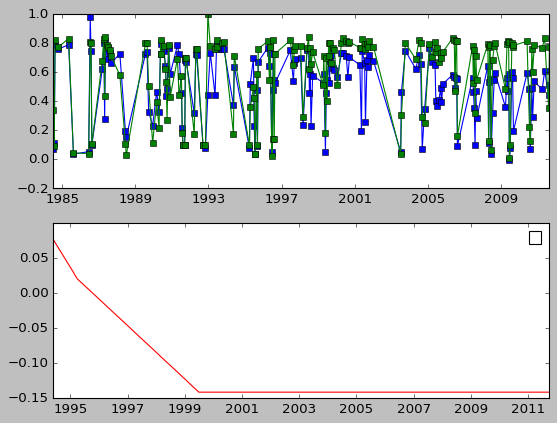

In [43]:
images = ee.ImageCollection([])
ndvis = ee.ImageCollection([])
datasets = ['LANDSAT/LT05/C01/T1_TOA'] #, 'LANDSAT/LE07/C01/T1_TOA', 'LANDSAT/LC08/C01/T1_TOA']
functions = [ndvi_l5] #, ndvi_l5, ndvi_l8]
for dataset, ndvi in zip(datasets, functions):
    x = get_landsat_images(path, row, start_date, end_date, dataset_path=dataset)
    x = x.filter(ee.Filter.lt('CLOUD_COVER', 50))
    images = ee.ImageCollection(x)
    ndvis = images.map(ndvi).map(set_mean)
    control = images.map(ndvi).map(set_background)
    dates = images.aggregate_array('system:time_start').getInfo()
    y1 = ndvis.aggregate_array('NDVI').getInfo()
    y2 = control.aggregate_array('NDVI').getInfo()
    if len(y1) > 0:
        dates = pd.to_datetime(dates, unit='ms')
        data1 = pd.DataFrame({'NDVI' : y1}, index=dates)
        data2 = pd.DataFrame({'NDVI' : y2}, index=dates)
        grouped1 = [group[1].dropna() for group in data1.groupby(pd.TimeGrouper('A'))]
        grouped2 = [group[1].dropna() for group in data2.groupby(pd.TimeGrouper('A'))]
        data1 = data1.groupby(pd.TimeGrouper('D')).mean().dropna()
        data2 = data2.groupby(pd.TimeGrouper('D')).mean().dropna()

fig, ax = plt.subplots(2,1)
ax[0].plot(data1.index, data1['NDVI'], data2.index, data2['NDVI'], marker='s', markersize=5)
plt.legend(['RMDD', 'Background'])

data1 = data1.resample('M').interpolate('linear')
data2 = data2.resample('M').interpolate('linear')
ax[1].plot(data1.index, data2['NDVI'] - data1['NDVI'], marker='', color='r', markersize=5)

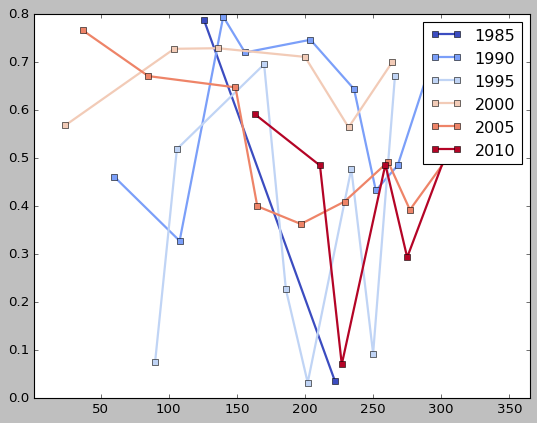

In [37]:
fig, ax = plt.subplots(1,1)
n_years = len(grouped1)
cycle = [plt.cm.coolwarm(i) for i in np.linspace(0, 1, int(n_years / 5) + 1)]
ax.set_color_cycle(cycle)
for dataset in grouped1:
    year = dataset.index.year[0]
    if year % 5 == 0:
        label = year
        ax.plot(dataset.index.dayofyear, dataset['NDVI'], marker='s', lw=2, label=label)
ax.set_xlim([1, 365])
plt.legend()

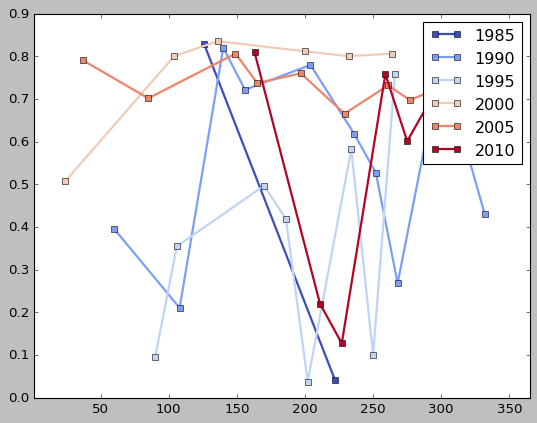

In [38]:
fig, ax = plt.subplots(1,1)
n_years = len(grouped2)
cycle = [plt.cm.coolwarm(i) for i in np.linspace(0, 1, int(n_years / 5) + 1)]
ax.set_color_cycle(cycle)
for dataset in grouped2:
    year = dataset.index.year[0]
    if year % 5 == 0:
        label = year
        ax.plot(dataset.index.dayofyear, dataset['NDVI'], marker='s', lw=2, label=label)
ax.set_xlim([1, 365])
plt.legend()